# Craigslist Car & Truck Price Modeling Notebook

In [167]:
import category_encoders as ce
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import ensemble, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from statsmodels.tools.eval_measures import rmse
import vtreat

In [169]:
sns.set(style='white')

## Data Loading

In [204]:
craig = pd.read_csv('craig.csv')

In [205]:
mask = (
    (craig.price > 1) &
    (craig.price <= 200000) &
    (craig.odometer < 1000000) |
    (craig.manufacturer == 'ferrari') |
    (craig.manufacturer == 'aston-martin')
)
craig = craig.loc[mask]

In [192]:
craig.columns

Index(['city', 'price', 'year', 'manufacturer', 'make', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'vin',
       'drive', 'size', 'type', 'paint_color', 'lat', 'long', 'county_fips',
       'county_name', 'state_fips', 'state_code', 'state_name', 'weather',
       'inf_model', 'lat_short', 'long_short', 'null_state_code',
       'vehicle_age', 'mileage_per_year', 'is_supercar', 'gross_color',
       'is_truck', 'pricey_state', 'is_auto_fwd', 'is_new',
       'f250_pricey_state', 'stang_pricey_state', 'pricey_model',
       'is_canadian', 'is_hot_coupe', 'is_hot_convertible', 'part_of_a_car',
       'is_salvage', 'no_vin', 'well_used', 'quarter_dead', 'silverfox_wagons',
       'condition_is_fair', 'condition_is_good', 'car_size_compact',
       'car_size_full-size', 'car_size_mid-size', 'car_size_sub-compact'],
      dtype='object')

In [206]:
#assigning nulls in the inferred model column to string 'nan' for vtreat
craig.loc[craig.inf_model.isna(), 'inf_model'] = 'nan'
craig.loc[craig.condition.isna(), 'condition'] = 'nan'
craig.loc[craig.cylinders.isna(), 'cylinders'] = 'nan'
craig.loc[craig.type.isna(), 'type'] = 'nan'
craig.loc[craig.paint_color.isna(), 'paint_color'] = 'nan'
craig.loc[craig.drive.isna(), 'drive'] = 'nan'
craig.loc[craig.title_status.isna(), 'title_status'] = 'nan'
craig.loc[craig.manufacturer.isna(), 'manufacturer'] = 'nan'
craig.loc[craig.transmission.isna(), 'transmission'] = 'nan'
craig.loc[craig['size'].isna(), 'size'] = 'nan'
craig.loc[craig.fuel.isna(), 'fuel'] = 'nan'
craig.loc[craig.city.isna(), 'city'] = 'nan'
craig.loc[craig.fuel == 'nan', 'fuel'].value_counts()

nan    6662
Name: fuel, dtype: int64

## Feature Engineering

In [207]:
craig['vehicle_age'] = 2019 - craig.year

craig['mileage_per_year'] = craig.odometer / craig.vehicle_age

mask = (
    (craig.manufacturer == 'ferrari') |
    (craig.manufacturer == 'aston-martin') | 
    (craig.manufacturer == 'noble') | 
    (craig.manufacturer == 'hennessey') 
)
craig.loc[:, 'is_supercar'] = 0
craig.loc[mask, 'is_supercar'] = 1

mask = (
    (craig.paint_color == 'brown') | 
    (craig.paint_color == 'purple') | 
    (craig.paint_color == 'green') 
)
craig.loc[:, 'gross_color'] = 0
craig.loc[mask, 'gross_color'] = 1

mask = (
    (craig.type == 'truck') |
    (craig.type == 'pickup')
)
craig.loc[:, 'is_truck'] = 0
craig.loc[mask, 'is_truck'] = 1

mask = (
    (craig.state_code == 'HI') |
    (craig.state_code == 'WA') | 
    (craig.state_code == 'AK')
)
craig.loc[:, 'pricey_state'] = 0
craig.loc[mask, 'pricey_state'] = 1

mask = (
    (craig.transmission == 'automatic') &
    (craig.drive == 'fwd')
)
craig.loc[:, 'is_auto_fwd'] = 0
craig.loc[mask, 'is_auto_fwd'] = 1

#needed to create this variable even though it exists in the condition column
#there is a lot of bad data there with very old cars being classified as new
mask = (
    (craig.year >= 2018) &
    (craig.odometer < 300)
)
craig.loc[:, 'is_new'] = 0
craig.loc[mask, 'is_new'] = 1

mask = (
    (craig.inf_model == 'f250') & 
    (craig.state_code == 'NC') |
    (craig.state_code == 'TX') |
    (craig.state_code == 'AL') |
    (craig.state_code == 'MD') |
    (craig.state_code == 'OK')
)
craig.loc[:, 'f250_pricey_state'] = 0
craig.loc[mask, 'f250_pricey_state'] = 1

mask = (
    (craig.inf_model == 'mustang') & 
    (craig.state_code == 'MT') |
    (craig.state_code == 'MN') |
    (craig.state_code == 'ME') |
    (craig.state_code == 'CO')
)
craig.loc[:, 'stang_pricey_state'] = 0    
craig.loc[mask, 'stang_pricey_state'] = 1

mask = (
    (craig.make == 'spider') |
    (craig.make == 'porsche911') |
    (craig.make == 'fpace') |
    (craig.make == 'giulia') |
    (craig.make == 'qx80') |
    (craig.make == 'qx460') |
    (craig.make == 'f650') |
    (craig.make == 'peterbilt') |
    (craig.make == 'evoque') |
    (craig.make == 'qx60')
)
craig.loc[:, 'pricey_model'] = 0    
craig.loc[mask, 'pricey_model'] = 1

craig.loc[:, 'is_canadian'] = 0
craig.loc[craig.state_code == 'CAN', 'is_canadian'] = 1

mask = (
    (craig.type == 'coupe') &
    (craig.paint_color == 'orange') |
    (craig.paint_color == 'yellow')
)
craig.loc[:, 'is_hot_coupe'] = 0
craig.loc[mask, 'is_hot_coupe'] = 1

mask = (
    (craig.type == 'convertible') &
    (craig.paint_color == 'orange') |
    (craig.paint_color == 'yellow') |
    (craig.paint_color == 'custom') |
    (craig.paint_color == 'purple')
)
craig.loc[:, 'is_hot_convertible'] = 0
craig.loc[mask, 'is_hot_convertible'] = 1

craig.loc[:, 'part_of_a_car'] = 0
craig.loc[(craig.title_status == 'parts only'), 'part_of_a_car'] = 1

craig.loc[:, 'is_salvage'] = 0
craig.loc[(craig.title_status == 'salvage'), 'is_salvage'] = 1

craig.loc[:, 'no_vin'] = 0
craig.loc[craig.vin.isna(), 'no_vin'] = 1

craig.loc[:, 'well_used'] = 0
craig.loc[(craig.odometer >= 200000), 'well_used'] = 1

mask = (
    (craig.vehicle_age < 25) &
    (craig.type != 'convertible') |
    (craig.type != 'coupe')
)
craig.loc[:, 'quarter_dead'] = 0
craig.loc[mask, 'quarter_dead'] = 1

mask = (
    (craig.type == 'wagon') & 
    (craig.vehicle_age > 50)
)
craig.loc[:, 'silverfox_wagons'] = 0
craig.loc[mask, 'silverfox_wagons'] = 1

craig.loc[:, 'condition_is_fair'] = 0
craig.loc[craig.condition == 'fair', 'condition_is_fair'] = 1

craig.loc[:, 'condition_is_good'] = 0
craig.loc[craig.condition == 'good', 'condition_is_good'] = 1

In [208]:
fullsize = pd.get_dummies(craig['size'], prefix='car_size')
craig = pd.concat([craig, fullsize], axis=1)

## Modeling

Columns with null values
vehicle_age    True
odometer       True
dtype: bool


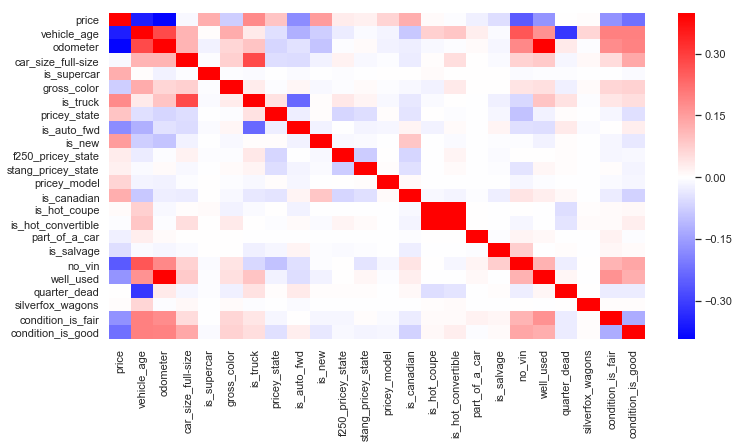

In [252]:
features = ['price',
            'vehicle_age', 
            'odometer',
            'condition',
            'car_size_full-size', 
            'is_supercar', 
            'gross_color', 
            'is_truck', 
            'pricey_state', 
            'is_auto_fwd', 
            'is_new',
            'f250_pricey_state',
            'stang_pricey_state',
            'pricey_model',
            'is_canadian',
            'is_hot_coupe',
            'is_hot_convertible',
            'part_of_a_car',
            'is_salvage',
            'no_vin',
            'well_used',
            'quarter_dead',
            'silverfox_wagons',
            'condition_is_fair',
            'condition_is_good',
            'inf_model',
            'cylinders',
            'type',
            'paint_color',
            'drive',
            'title_status',
            'manufacturer',
            'transmission',
            'fuel',
            'city'
           ]

model_df = craig.loc[:, features]

null_df = model_df.isnull().any() 
print('Columns with null values\n{}'.format(null_df[null_df == True]))

model_df.dropna(inplace=True)

plt.figure(figsize=(12,6))
sns.heatmap(model_df.corr(), cmap='bwr', center=0, vmax=0.4)
plt.show()

In [217]:
model_df.columns

Index(['price', 'vehicle_age', 'odometer', 'car_size_full-size', 'is_supercar',
       'gross_color', 'is_truck', 'pricey_state', 'is_auto_fwd', 'is_new',
       'f250_pricey_state', 'stang_pricey_state', 'pricey_model',
       'is_canadian', 'is_hot_coupe', 'is_hot_convertible', 'part_of_a_car',
       'is_salvage', 'no_vin', 'well_used', 'quarter_dead', 'silverfox_wagons',
       'condition_is_fair', 'condition_is_good', 'inf_model', 'cylinders',
       'type', 'paint_color', 'drive', 'title_status', 'manufacturer',
       'transmission', 'fuel', 'city', 'fuel'],
      dtype='object')

### Train/Test Split

In [221]:
model_df = model_df.loc[model_df.price <= 50000]
X = model_df.loc[:, model_df.columns != 'price']
Y = model_df['price'].apply(np.log10)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 38)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 38)
print('The number of observations in training: {}'.format(len(X_train)))
print('The number of observations in validation: {}'.format(len(X_val)))
print('The number of observations in test: {}'.format(len(X_test)))

#used StandardScaler before inplementing vtreat workflow
#s = StandardScaler()
#X_train = s.fit_transform(X_train)
#X_val = s.transform(X_val)
#X_test = s.transform(X_test)

vtreat_transform = vtreat.NumericOutcomeTreatment(outcome_name='price')
X_train_prepared = vtreat_transform.fit_transform(X_train, Y_train)

# apply to validation and test set
X_val_prepared = vtreat_transform.transform(X_val)
X_test_prepared = vtreat_transform.transform(X_test)

The number of observations in training: 624480
The number of observations in validation: 156121
The number of observations in test: 195151


In [250]:
#print(X_train_prepared.transmission_prevalence_code.value_counts())
#print(X.transmission.value_counts())
#print(model_df.groupby('transmission')['price'].mean())

impact = pd.concat([X_train_prepared, Y_train], axis=1)
print(impact.groupby('transmission_impact_code')['price'].mean())

transmission_impact_code
-0.101129    3.906027
-0.100981    3.919303
-0.100829    3.916280
-0.100470    3.917993
-0.098767    3.915682
 0.004255    3.912466
 0.004340    3.915013
 0.004357    3.913791
 0.004363    3.913451
 0.004488    3.918324
 0.223690    3.966483
 0.224436    3.958075
 0.225052    3.938975
 0.226649    3.914591
 0.229224    3.957399
 0.264134    3.893361
 0.264140    3.928819
 0.265398    3.947416
 0.265729    3.909609
 0.269079    3.910101
Name: price, dtype: float64


### Random Forest

#### RF Bayes Optimization & Initial .fit()

In [35]:
rfr = ensemble.RandomForestRegressor(n_jobs=-1)

params = {
    'n_estimators':Integer(200, 1000, 'normalize'),
    'criterion':Categorical(['mse']),
    'max_depth':Integer(2, 10, 'normalize'),
    'min_samples_leaf':Integer(10, 1000, 'normalize'),
    'max_features':Integer(1, 23, 'normalize')
}

opt = BayesSearchCV(
    rfr,
    params,
    cv=5,
    n_iter=5,
    random_state=5
)

opt.fit(X_train, Y_train)

print(opt.best_params_)

{'criterion': 'mse', 'max_depth': 9, 'max_features': 21, 'min_samples_leaf': 987, 'n_estimators': 251}


In [56]:
Y_train_pred = opt.predict(X_train)
norm_Y_train_pred = []
for x in Y_train_pred:
    norm_Y_train_pred.append(math.exp(x))
    
Y_val_pred = opt.predict(X_val)
norm_Y_val_pred = []
for x in Y_val_pred:
    norm_Y_val_pred.append(math.exp(x))


print('$$$$$$$$$$     Random Forest Training Stats     $$$$$$$$$$\n')
print('Random Forest r^2: {:.6f}'.format(opt.score(X_train, Y_train)))
print('Random Forest rmse: {:.2f}'.format(rmse(Y_train.apply(lambda x: math.exp(x)), norm_Y_train_pred)))

print('\n\n$$$$$$$$$$     Random Forest Validation Stats     $$$$$$$$$$\n')
print('Random Forest r^2: {:.6f}'.format(opt.score(X_val, Y_val)))
print('Random Forest rmse: {:.2f}'.format(rmse(Y_val.apply(lambda x: math.exp(x)), norm_Y_val_pred)))

"""""
print('\n\n$$$$$$$$$$     Random Forest Feature Importances     $$$$$$$$$$\n')
feature_importance = rfr.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()
"""""

$$$$$$$$$$     Random Forest Training Stats     $$$$$$$$$$

Random Forest r^2: 0.581340
Random Forest rmse: 8189.30


$$$$$$$$$$     Random Forest Validation Stats     $$$$$$$$$$

Random Forest r^2: 0.579508
Random Forest rmse: 8182.87


'""\nprint(\'\n\n$$$$$$$$$$     Random Forest Feature Importances     $$$$$$$$$$\n\')\nfeature_importance = rfr.feature_importances_\n\n# Make importances relative to max importance.\nfeature_importance = 100.0 * (feature_importance / feature_importance.max())\nsorted_idx = np.argsort(feature_importance)\npos = np.arange(sorted_idx.shape[0]) + .5\n\nplt.barh(pos, feature_importance[sorted_idx], align=\'center\')\nplt.yticks(pos, X.columns[sorted_idx])\nplt.xlabel(\'Relative Importance\')\nplt.title(\'Variable Importance\')\nplt.show()\n'

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


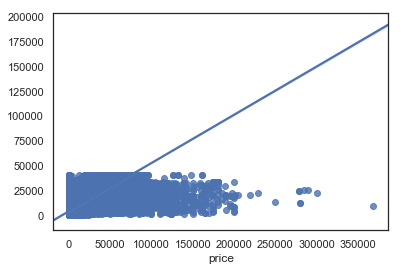

In [60]:
sns.regplot(
    x=Y_train.apply(lambda x: math.exp(x)),
    y=norm_Y_train_pred
)
plt.show()

#### RF iteration 2 with tuned HP

$$$$$$$$$$     Random Forest Training Stats     $$$$$$$$$$

Random Forest r^2: 0.58
Random Forest rmse: 54.50


$$$$$$$$$$     Random Forest Validation Stats     $$$$$$$$$$

Random Forest r^2: 0.58
Random Forest rmse: 54.48


$$$$$$$$$$     Random Forest Feature Importances     $$$$$$$$$$



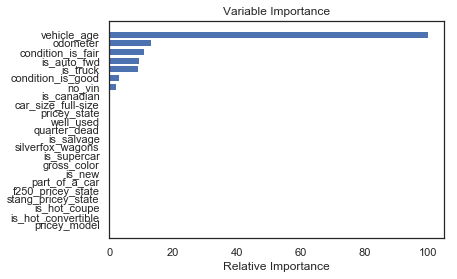

In [62]:
rfr = ensemble.RandomForestRegressor(
    criterion='mse', 
    max_depth=9,
    max_features=21,
    min_samples_leaf=987,
    n_estimators=251,
    n_jobs=-2
)

rfr.fit(X_train, Y_train)

$$$$$$$$$$     Random Forest Training Stats     $$$$$$$$$$

Random Forest r^2: 0.58
Random Forest rmse: 8189.82


$$$$$$$$$$     Random Forest Validation Stats     $$$$$$$$$$

Random Forest r^2: 0.58
Random Forest rmse: 8183.02


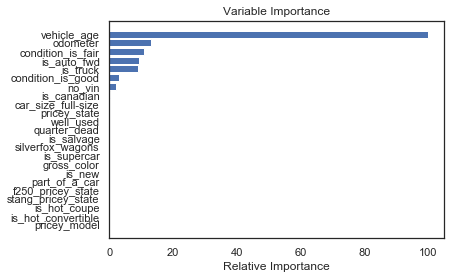

In [79]:
Y_train_pred = rfr.predict(X_train)
norm_Y_train_pred = []
for x in Y_train_pred:
    norm_Y_train_pred.append(10**x)
    
Y_val_pred = rfr.predict(X_val)
norm_Y_val_pred = []
for x in Y_val_pred:
    norm_Y_val_pred.append(10**x)

print('$$$$$$$$$$     Random Forest Training Stats     $$$$$$$$$$\n')
print('Random Forest r^2: {:.2f}'.format(rfr.score(X_train, Y_train)))
print('Random Forest rmse: {:.2f}'.format(rmse(Y_train.apply(lambda x: 10**x), norm_Y_train_pred)))

print('\n\n$$$$$$$$$$     Random Forest Validation Stats     $$$$$$$$$$\n')
print('Random Forest r^2: {:.2f}'.format(rfr.score(X_val, Y_val)))
print('Random Forest rmse: {:.2f}'.format(rmse(Y_val.apply(lambda x: 10**x), norm_Y_val_pred)))

feature_importance = rfr.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

sns.set_style('white')
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


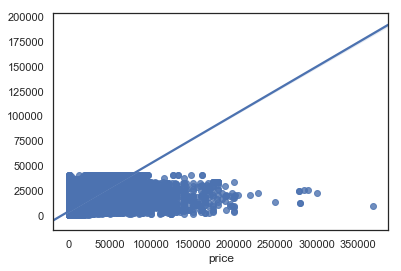

In [80]:
sns.regplot(
    x=Y_train.apply(lambda x: 10**x),
    y=norm_Y_train_pred
)
plt.show()

#### RF iteration 3 price <= 50,000

In [137]:
#since Random forest would not predict over 50k, let's remove that data and try again
model_df = model_df.loc[model_df.price <= 50000]
X = model_df.drop(['price'], axis=1)
Y = model_df['price'].apply(np.log10)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 38)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 38)
print('The number of observations in training: {}'.format(len(X_train)))
print('The number of observations in validation: {}'.format(len(X_val)))
print('The number of observations in test: {}'.format(len(X_test)))

s = StandardScaler()
X_train = s.fit_transform(X_train)
X_val = s.transform(X_val)
X_test = s.transform(X_test)

The number of observations in training: 624480
The number of observations in validation: 156121
The number of observations in test: 195151


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  del sys.path[0]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


$$$$$$$$$$     Random Forest Training Stats     $$$$$$$$$$

Random Forest r^2: 0.57
Random Forest rmse: 6227.86


$$$$$$$$$$     Random Forest Validation Stats     $$$$$$$$$$

Random Forest r^2: 0.57
Random Forest rmse: 6243.52


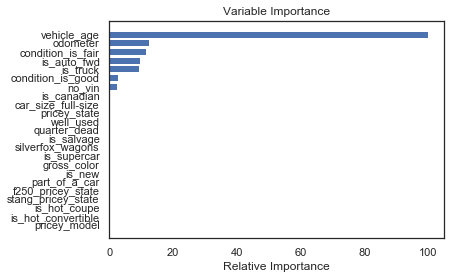

In [138]:
rfr = ensemble.RandomForestRegressor(
    criterion='mse', 
    max_depth=9,
    max_features=21,
    min_samples_leaf=987,
    n_estimators=251,
    n_jobs=-2
)

rfr.fit(X_train, Y_train)

Y_train_pred = rfr.predict(X_train)
norm_Y_train_pred = []
for x in Y_train_pred:
    norm_Y_train_pred.append(10**x)
    
Y_val_pred = rfr.predict(X_val)
norm_Y_val_pred = []
for x in Y_val_pred:
    norm_Y_val_pred.append(10**x)

print('$$$$$$$$$$     Random Forest Training Stats     $$$$$$$$$$\n')
print('Random Forest r^2: {:.2f}'.format(rfr.score(X_train, Y_train)))
print('Random Forest rmse: {:.2f}'.format(rmse(Y_train.apply(lambda x: 10**x), norm_Y_train_pred)))

print('\n\n$$$$$$$$$$     Random Forest Validation Stats     $$$$$$$$$$\n')
print('Random Forest r^2: {:.2f}'.format(rfr.score(X_val, Y_val)))
print('Random Forest rmse: {:.2f}'.format(rmse(Y_val.apply(lambda x: 10**x), norm_Y_val_pred)))

feature_importance = rfr.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

sns.set_style('white')
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

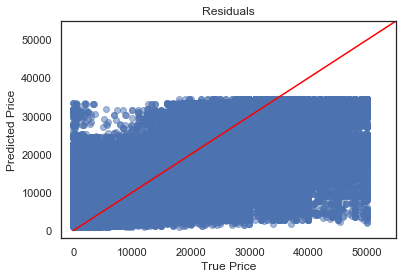

In [142]:
plt.scatter(
    x=Y_train.apply(lambda x: 10**x),
    y=norm_Y_train_pred,
    alpha=0.5
)
plt.plot(range(60000), color='red')
plt.xlabel('True Price')
plt.ylabel('Predicted Price')
plt.title('Residuals')
plt.xlim(-2000, 55000)
plt.ylim(-2000, 55000)
plt.show()

#### RF Iteration 4 with vtreat and price < 50k

In [235]:
rfr = ensemble.RandomForestRegressor(
    criterion='mse', 
    max_depth=9,
    max_features=21,
    min_samples_leaf=987,
    n_estimators=251,
    n_jobs=-2
)

rfr.fit(X_train_prepared, Y_train)

Y_train_pred = rfr.predict(X_train_prepared)
norm_Y_train_pred = []
for x in Y_train_pred:
    norm_Y_train_pred.append(10**x)
    
Y_val_pred = rfr.predict(X_val_prepared)
norm_Y_val_pred = []
for x in Y_val_pred:
    norm_Y_val_pred.append(10**x)

print('$$$$$$$$$$     Random Forest Training Stats     $$$$$$$$$$\n')
print('Random Forest r^2: {:.2f}'.format(rfr.score(X_train_prepared, Y_train)))
print('Random Forest rmse: {:.2f}'.format(rmse(Y_train.apply(lambda x: 10**x), norm_Y_train_pred)))

print('\n\n$$$$$$$$$$     Random Forest Validation Stats     $$$$$$$$$$\n')
print('Random Forest r^2: {:.2f}'.format(rfr.score(X_val_prepared, Y_val)))
print('Random Forest rmse: {:.2f}'.format(rmse(Y_val.apply(lambda x: 10**x), norm_Y_val_pred)))

$$$$$$$$$$     Random Forest Training Stats     $$$$$$$$$$

Random Forest r^2: 0.67
Random Forest rmse: 5245.65


$$$$$$$$$$     Random Forest Validation Stats     $$$$$$$$$$

Random Forest r^2: 0.66
Random Forest rmse: 5270.66


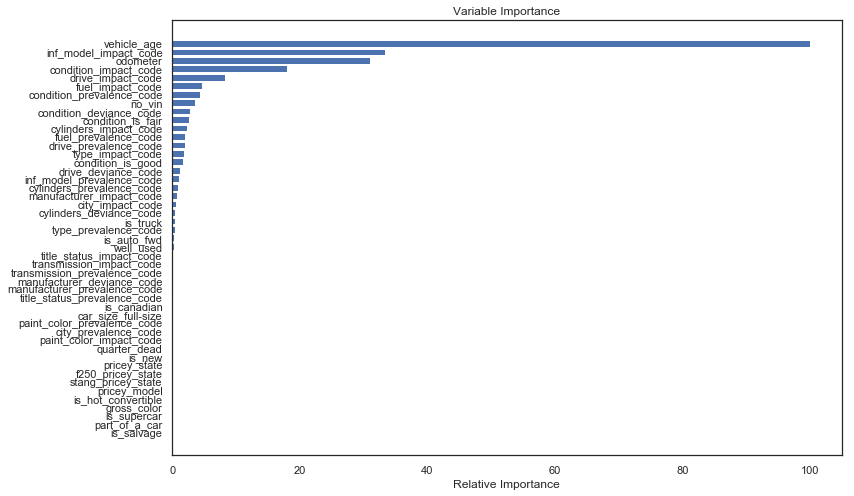

In [236]:
feature_importance = rfr.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12, 8))
sns.set_style('white')
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train_prepared.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

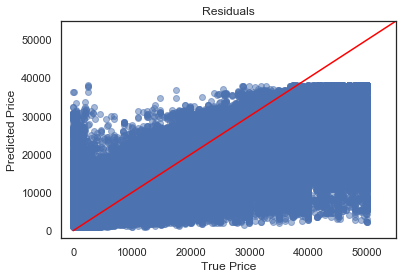

In [238]:
plt.scatter(
    x=Y_train.apply(lambda x: 10**x),
    y=norm_Y_train_pred,
    alpha=0.5
)
plt.plot(range(350000), color='red')
plt.xlabel('True Price')
plt.ylabel('Predicted Price')
plt.title('Residuals')
plt.xlim(-2000, 55000)
plt.ylim(-2000, 55000)
plt.show()

### Gradient Boosting

#### GBR bayes opt

In [234]:
#Code failed due to computational resources, likely due to the high n_estimators
#could potentially work by not iterating n_estimators and leaving it at 10
"""""
gbr = ensemble.GradientBoostingRegressor()

params = {
    'n_estimators':Integer(100, 500, 'normalize'),
    'subsample':Real(0.2, 1.0, 'uniform'),
    'criterion':Categorical(['friedman_mse', 'mse', 'mae']),
    'max_depth':Integer(2, 10, 'normalize'),
    'max_features':Integer(1, 23, 'normalize')
}

opt = BayesSearchCV(
    gbr,
    params,
    cv=5,
    n_iter=5,
    random_state=874,
    scoring='neg_mean_squared_error'
)

opt.fit(X_train, Y_train)

print(opt.best_params_)
"""""

'""\ngbr = ensemble.GradientBoostingRegressor()\n\nparams = {\n    \'n_estimators\':Integer(100, 500, \'normalize\'),\n    \'subsample\':Real(0.2, 1.0, \'uniform\'),\n    \'criterion\':Categorical([\'friedman_mse\', \'mse\', \'mae\']),\n    \'max_depth\':Integer(2, 10, \'normalize\'),\n    \'max_features\':Integer(1, 23, \'normalize\')\n}\n\nopt = BayesSearchCV(\n    gbr,\n    params,\n    cv=5,\n    n_iter=5,\n    random_state=874,\n    scoring=\'neg_mean_squared_error\'\n)\n\nopt.fit(X_train, Y_train)\n\nprint(opt.best_params_)\n'

#### GBR iteration 1 with best guess parameters

In [253]:
X = model_df.loc[:, model_df.columns != 'price']
Y = model_df['price'].apply(np.log10)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 38)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 38)
print('The number of observations in training: {}'.format(len(X_train)))
print('The number of observations in validation: {}'.format(len(X_val)))
print('The number of observations in test: {}'.format(len(X_test)))

s = StandardScaler()
X_train = s.fit_transform(X_train)
X_val = s.transform(X_val)
X_test = s.transform(X_test)

The number of observations in training: 631329
The number of observations in validation: 157833
The number of observations in test: 197291


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  del sys.path[0]


In [254]:
gbr = ensemble.GradientBoostingRegressor(
    n_estimators=300,
    subsample=0.8,
    criterion='mse',
    max_depth=10,
    random_state=84,
    max_features=23,
)

gbr.fit(X_train, Y_train)

GradientBoostingRegressor(alpha=0.9, criterion='mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=10, max_features=23,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=300, n_iter_no_change=None, presort='auto',
             random_state=84, subsample=0.8, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [255]:
Y_train_pred = gbr.predict(X_train)
norm_Y_train_pred = []
for x in Y_train_pred:
    norm_Y_train_pred.append(10**x)
    
Y_val_pred = gbr.predict(X_val)
norm_Y_val_pred = []
for x in Y_val_pred:
    norm_Y_val_pred.append(10**x)

print('$$$$$$$$$$     Gradient Boosting Training Stats     $$$$$$$$$$\n')
print('Gradient Boosting r^2: {:.2f}'.format(gbr.score(X_train, Y_train)))
print('Gradient Boosting rmse: {:.2f}'.format(rmse(Y_train.apply(lambda x: 10**x), norm_Y_train_pred)))

print('\n\n$$$$$$$$$$     Gradient Boosting Validation Stats     $$$$$$$$$$\n')
print('Gradient Boosting r^2: {:.2f}'.format(gbr.score(X_val, Y_val)))
print('Gradient Boosting rmse: {:.2f}'.format(rmse(Y_val.apply(lambda x: 10**x), norm_Y_val_pred)))

$$$$$$$$$$     Gradient Boosting Training Stats     $$$$$$$$$$

Gradient Boosting r^2: 0.68
Gradient Boosting rmse: 7056.15


$$$$$$$$$$     Gradient Boosting Validation Stats     $$$$$$$$$$

Gradient Boosting r^2: 0.62
Gradient Boosting rmse: 7466.98


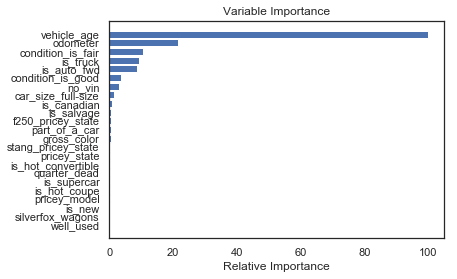

In [119]:
feature_importance = gbr.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

sns.set_style('white')
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

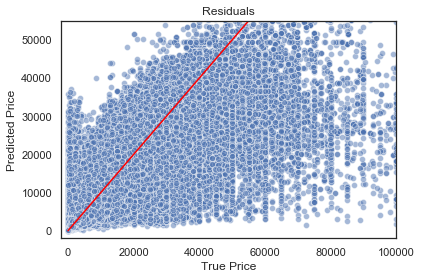

In [112]:
sns.scatterplot(
    x=Y_train.apply(lambda x: 10**x),
    y=norm_Y_train_pred,
    alpha=0.5
)
plt.plot(range(300000), color='red')
plt.xlabel('True Price')
plt.ylabel('Predicted Price')
plt.title('Residuals')
plt.xlim(-2000, 100000)
plt.ylim(-2000, 55000)
plt.show()

In [118]:
y_df = pd.DataFrame()
y_df['Y_train'] = Y_train.apply(lambda x: 10**x)
y_df['Y_train_pred'] = norm_Y_train_pred

low_price = y_df.loc[y_df.Y_train < 50000]
print('rmse: ${:,.2f}'.format(rmse(low_price.Y_train, low_price.Y_train_pred)))
print('Average price of training rows < 50k: ${:,.2f}'.format(low_price.Y_train.mean()))
print('Total rows where price < 50k: {:,}'.format(len(low_price)))
print('Total training rows: {:,}'.format(len(Y_train)))
print('% of model where rmse = ${:,.2f}: {:.2f}%'.format(rmse(low_price.Y_train, low_price.Y_train_pred),(100 * (len(low_price)/len(Y_train))))

rmse: $5,514.61
Average price of training rows < 50k: $11,544.09
Total rows where price < 50k: 624,520
Total training rows: 631,329
% of model where rmse = above: 98.92%


#### GBR iteration 2 with vtreat and price < 50k,

In [223]:
gbr = ensemble.GradientBoostingRegressor(
    n_estimators=400,
    subsample=0.8,
    criterion='mse',
    max_depth=12,
    random_state=84,
    max_features=23,
    verbose=1,
    tol=0.004
)

gbr.fit(X_train_prepared, Y_train)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.1677           0.0253         1273.89m
         2           0.1468           0.0206         1276.87m
         3           0.1292           0.0170         1273.88m
         4           0.1142           0.0138         1277.72m
         5           0.1024           0.0113         1268.94m
         6           0.0925           0.0094         1267.11m
         7           0.0839           0.0078         1254.47m
         8           0.0773           0.0063         1251.59m
         9           0.0716           0.0052         1223.46m
        10           0.0670           0.0044         1205.30m
        20           0.0434           0.0008         1076.78m
        30           0.0364           0.0003          970.94m
        40           0.0328           0.0001          882.85m
        50           0.0307           0.0000          807.98m
        60           0.0290           0.0000          728.10m
       

GradientBoostingRegressor(alpha=0.9, criterion='mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=12, max_features=23,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=400, n_iter_no_change=None, presort='auto',
             random_state=84, subsample=0.8, tol=0.004,
             validation_fraction=0.1, verbose=1, warm_start=False)

In [224]:
Y_train_pred = gbr.predict(X_train_prepared)
norm_Y_train_pred = []
for x in Y_train_pred:
    norm_Y_train_pred.append(10**x)

Y_val_pred = gbr.predict(X_val_prepared)
norm_Y_val_pred = []
for x in Y_val_pred:
    norm_Y_val_pred.append(10**x)  
    
print(gbr.score(X_train_prepared, Y_train))
print(rmse(Y_train.apply(lambda x: 10**x), norm_Y_train_pred))

print('$$$$$$$$$$     Gradient Boosting Training Stats     $$$$$$$$$$\n')
print('Gradient Boosting r^2: {:.2f}'.format(gbr.score(X_train_prepared, Y_train)))
print('Gradient Boosting rmse: {:.2f}'.format(rmse(Y_train.apply(lambda x: 10**x), norm_Y_train_pred)))

print('\n\n$$$$$$$$$$     Gradient Boosting Validation Stats     $$$$$$$$$$\n')
print('Gradient Boosting r^2: {:.2f}'.format(gbr.score(X_val_prepared, Y_val)))
print('Gradient Boosting rmse: {:.2f}'.format(rmse(Y_val.apply(lambda x: 10**x), norm_Y_val_pred)))

0.9527185846960837
2193.0627904808657
$$$$$$$$$$     Gradient Boosting Training Stats     $$$$$$$$$$

Gradient Boosting r^2: 0.95
Gradient Boosting rmse: 2193.06


$$$$$$$$$$     Gradient Boosting Validation Stats     $$$$$$$$$$

Gradient Boosting r^2: 0.78
Gradient Boosting rmse: 3614.61


#### GBR iteration 3 with vtreat, price < 50k, and overfitting solutions

In [228]:
gbr = ensemble.GradientBoostingRegressor(
    n_estimators=20,
    criterion='mse',
    max_depth=12,
    random_state=84,
    max_features=47,
    verbose=2
)

gbr.fit(X_train_prepared, Y_train)

      Iter       Train Loss   Remaining Time 
         1           0.1677           60.49m
         2           0.1460           57.80m
         3           0.1282           53.82m
         4           0.1136           50.32m
         5           0.1015           47.48m
         6           0.0914           43.65m
         7           0.0831           40.02m
         8           0.0762           36.86m
         9           0.0702           33.41m
        10           0.0653           30.22m
        11           0.0611           27.05m
        12           0.0574           23.94m
        13           0.0543           20.88m
        14           0.0516           18.52m
        15           0.0493           15.96m
        16           0.0474           13.06m
        17           0.0456           10.03m
        18           0.0441            6.78m
        19           0.0427            3.43m
        20           0.0415            0.00s


GradientBoostingRegressor(alpha=0.9, criterion='mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=12, max_features=47,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=20, n_iter_no_change=None, presort='auto',
             random_state=84, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=2, warm_start=False)

In [230]:
Y_train_pred = gbr.predict(X_train_prepared)
norm_Y_train_pred = []
for x in Y_train_pred:
    norm_Y_train_pred.append(10**x)

Y_val_pred = gbr.predict(X_val_prepared)
norm_Y_val_pred = []
for x in Y_val_pred:
    norm_Y_val_pred.append(10**x)  

print('$$$$$$$$$$     Gradient Boosting Training Stats     $$$$$$$$$$\n')
print('Gradient Boosting r^2: {:.2f}'.format(gbr.score(X_train_prepared, Y_train)))
print('Gradient Boosting rmse: {:.2f}'.format(rmse(Y_train.apply(lambda x: 10**x), norm_Y_train_pred)))

print('\n\n$$$$$$$$$$     Gradient Boosting Validation Stats     $$$$$$$$$$\n')
print('Gradient Boosting r^2: {:.2f}'.format(gbr.score(X_val_prepared, Y_val)))
print('Gradient Boosting rmse: {:.2f}'.format(rmse(Y_val.apply(lambda x: 10**x), norm_Y_val_pred)))

$$$$$$$$$$     Gradient Boosting Training Stats     $$$$$$$$$$

Gradient Boosting r^2: 0.79
Gradient Boosting rmse: 4531.05


$$$$$$$$$$     Gradient Boosting Validation Stats     $$$$$$$$$$

Gradient Boosting r^2: 0.73
Gradient Boosting rmse: 4799.27


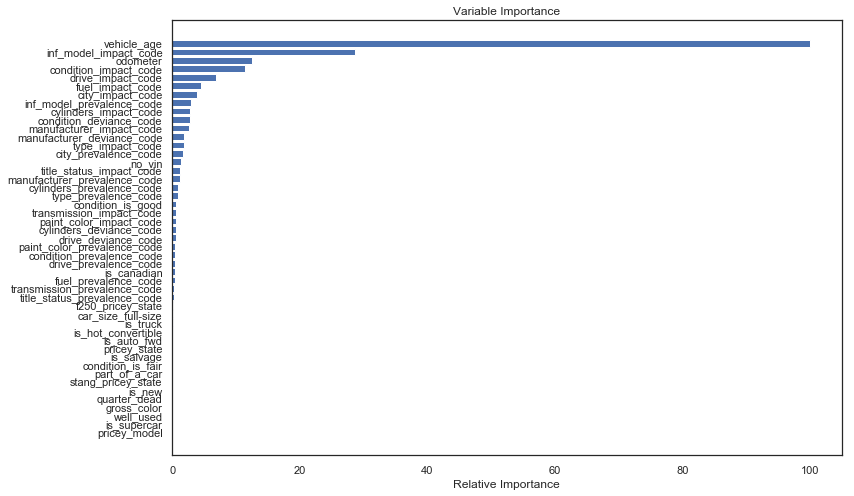

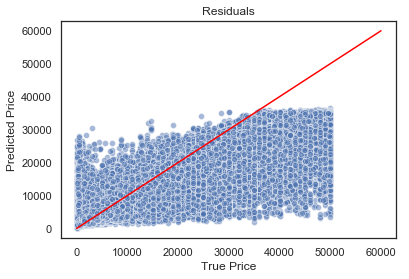

In [233]:
feature_importance = gbr.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12,8))
sns.set_style('white')
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train_prepared.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

sns.scatterplot(
    x=Y_train.apply(lambda x: 10**x),
    y=norm_Y_train_pred,
    alpha=0.5
)
plt.plot(range(60000), color='red')
plt.xlabel('True Price')
plt.ylabel('Predicted Price')
plt.title('Residuals')
#plt.xlim(-2000, 100000)
#plt.ylim(-2000, 55000)
plt.show()

In [251]:
Y_test_pred = gbr.predict(X_test_prepared)
norm_Y_test_pred = []
for x in Y_test_pred:
    norm_Y_test_pred.append(10**x)  

print('$$$$$$$$$$     Gradient Boosting Test Stats     $$$$$$$$$$\n')
print('Gradient Boosting r^2: {:.2f}'.format(gbr.score(X_test_prepared, Y_test)))
print('Gradient Boosting rmse: {:.2f}'.format(rmse(Y_test.apply(lambda x: 10**x), norm_Y_test_pred)))

$$$$$$$$$$     Gradient Boosting Test Stats     $$$$$$$$$$

Gradient Boosting r^2: 0.73
Gradient Boosting rmse: 4764.02
